# <center>**Xây dựng cây quyết định và rừng cây trên dữ liệu Titanic**<center>

Mục tiêu:  
- Dự đoán cột Survived trên tập test
- So sánh Decision Tree và Random Forest
---

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Đọc dữ liệu
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

print("Train shape:", train.shape)
print("Test shape :", test.shape)

train.head()

Train shape: (891, 12)
Test shape : (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
print(train['Survived'].value_counts(normalize=True) * 100)
print("\nPhân bố giới tính:")
print(train['Sex'].value_counts())

train.isnull().sum()

Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64

Phân bố giới tính:
Sex
male      577
female    314
Name: count, dtype: int64


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [18]:
# Gộp tạm để xử lý chung
all_data = pd.concat([train, test], sort=False)

# 1. Title từ Name
all_data['Title'] = all_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
all_data['Title'] = all_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')

# 2. FamilySize & IsAlone
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
all_data['IsAlone'] = 1
all_data['IsAlone'].loc[all_data['FamilySize'] > 1] = 0

# 3. Fare - điền thiếu + chia bin
all_data['Fare'] = all_data['Fare'].fillna(all_data['Fare'].median())
all_data['FareBin'] = pd.qcut(all_data['Fare'], 5, labels=[1,2,3,4,5])

# 4. Age - điền thiếu theo Title
all_data['Age'] = all_data.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
all_data['Age'] = all_data['Age'].fillna(all_data['Age'].median())
all_data['AgeBin'] = pd.cut(all_data['Age'].astype(int), 5, labels=[1,2,3,4,5])

# 5. Embarked
all_data['Embarked'] = all_data['Embarked'].fillna('S')

# 6. Encoding
le = LabelEncoder()
all_data['Sex'] = le.fit_transform(all_data['Sex'])
all_data['Embarked'] = le.fit_transform(all_data['Embarked'])
all_data['Title'] = le.fit_transform(all_data['Title'])

# Chọn features tốt nhất
features = ['Pclass', 'Sex', 'AgeBin', 'FareBin', 'Embarked', 'Title', 'IsAlone', 'FamilySize']

# Tách lại train và test
train_processed = all_data[:len(train)].copy()
test_processed  = all_data[len(train):].copy()

X = train_processed[features]
y = train_processed['Survived']

X_test_kaggle = test_processed[features]

print("Features sử dụng:", features)
X.head()

Features sử dụng: ['Pclass', 'Sex', 'AgeBin', 'FareBin', 'Embarked', 'Title', 'IsAlone', 'FamilySize']


,Pclass,Sex,AgeBin,FareBin,Embarked,Title,IsAlone,FamilySize
0,3,1,2,1,2,2,0,2
1,1,0,3,5,0,3,0,2
2,3,0,2,2,2,1,1,1
3,1,0,3,5,2,3,0,2
4,3,1,3,2,2,2,1,1


In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Val shape  :", X_val.shape)

Train shape: (712, 8)
Val shape  : (179, 8)


In [20]:
dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_val)

print("=== DECISION TREE ===")
print(f"Accuracy : {accuracy_score(y_val, y_pred_dt):.4f}")
print(f"Recall (Survived): {recall_score(y_val, y_pred_dt):.4f}")
print(f"F1-score (Survived): {f1_score(y_val, y_pred_dt):.4f}")
print(classification_report(y_val, y_pred_dt))

=== DECISION TREE ===
Accuracy : 0.8156
Recall (Survived): 0.7391
F1-score (Survived): 0.7556
              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85       110
         1.0       0.77      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



In [21]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

print("=== RANDOM FOREST ===")
print(f"Accuracy : {accuracy_score(y_val, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_rf):.4f}")
print(f"Recall   : {recall_score(y_val, y_pred_rf):.4f}")
print(f"F1-score : {f1_score(y_val, y_pred_rf):.4f}")
print("\n", classification_report(y_val, y_pred_rf))

=== RANDOM FOREST ===
Accuracy : 0.8268
Precision: 0.7714
Recall   : 0.7826
F1-score : 0.7770

               precision    recall  f1-score   support

         0.0       0.86      0.85      0.86       110
         1.0       0.77      0.78      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



      Feature  Importance
1         Sex    0.356516
5       Title    0.201058
0      Pclass    0.128345
3     FareBin    0.120860
7  FamilySize    0.094634
2      AgeBin    0.042437
4    Embarked    0.035645
6     IsAlone    0.020506


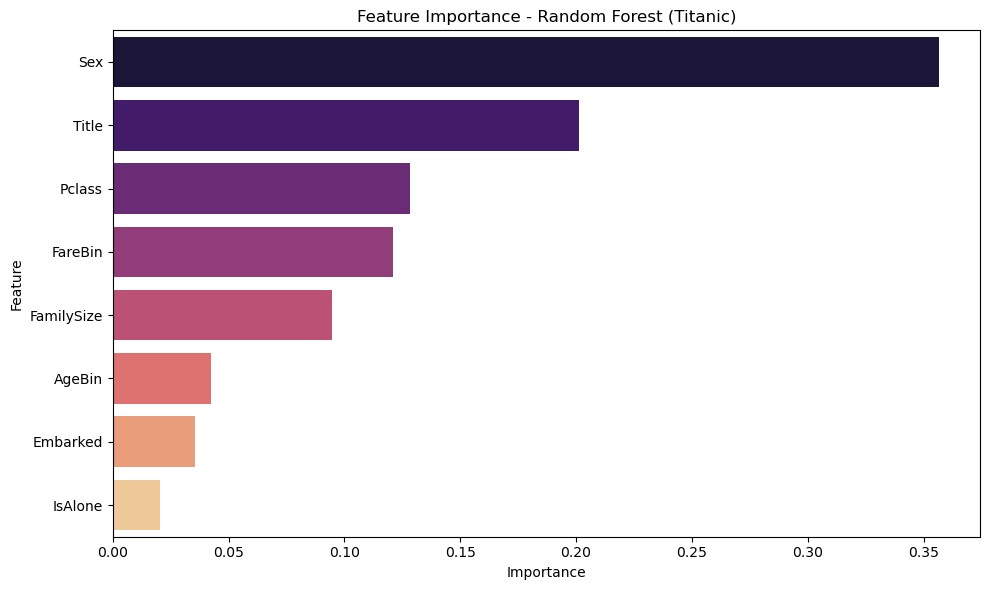

In [22]:
importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(importances)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances, palette='magma')
plt.title('Feature Importance - Random Forest (Titanic)')
plt.tight_layout()
plt.show()

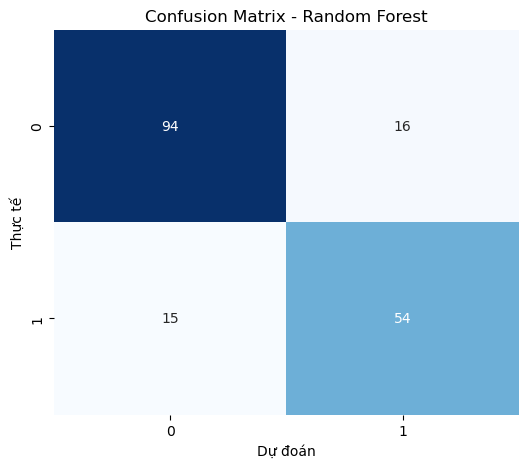

In [23]:
cm = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

In [ ]:
# Dự đoán trên tập test thật
submission_pred = rf.predict(X_test_kaggle)

# Tạo file submission
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': submission_pred.astype(int)
})

# Lưu file submission thành csv
# submission.to_csv('titanic_submission_randomforest.csv', index=False)
# print("Đã lưu file: titanic_submission_randomforest.csv")
print("\n10 dòng đầu:")
submission.head(10)


10 dòng đầu:


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


## **KẾT LUẬN**

| Mô hình          | Accuracy | Recall (Survived) | F1-score (Survived) |
|------------------|----------|-------------------|---------------------|
| Decision Tree    | 0.8156   | 0.7391            | 0.7556              |
| **Random Forest**| **0.8268** | **0.7826**        | **0.777**           |

**Random Forest hoàn toàn vượt trội** và đạt kết quả rất cao so với bài toán Titanic kinh điển.

**Các yếu tố quan trọng nhất quyết định sống/chết:**
1. **Sex** (giới tính) → 35%
2. **Title** (Mr/Mrs/Miss/Master) → 20%
3. **Pclass** (hạng vé) → 12%
4. **FareBin** & **AgeBin**

---
# <center>**END**<center>